In [46]:
import apd_utils as apd
import numpy as np 
import pandas as pd
import random

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Generate a referenced dataset and a random sample and perform DBSCAN
The initial step involves generating a referenced dataset and establishing a generic analytical workflow. To evaluate a sample, only five steps are necessary, as outlined below. It is important to note that in this case, a non-adulterated sample is generated, which means that the label predicted by DBSCAN for the sample should be identical to the labels of the referenced samples.

In [3]:
# 1. Generate a referenced dataset to represent authentic products
data_ref = apd.generate_ref_data(num_sample=50, num_analyte=200, seed=32)

# 2. Generate a non-adulterated random sample
sample_ref = apd.generate_random_sample(data_ref, adulterated=False, seed=64)

# 3. Combine referenced data and the random sample
data_comb = np.concatenate((data_ref, sample_ref), axis=0)

# 4. Scale the data  
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_comb)

# 5. Perform DBSCAN on scaled data
dbscan = DBSCAN(eps=20).fit(scaled_data)

print(f"Labels for referenced data: {dbscan.labels_[0:30]}")
print(f"Label for the non-adulterated sample: {dbscan.labels_[-1]}")

Labels for referenced data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Label for the non-adulterated sample: 0


## 2. Generate some adulterated samples and perform DBSCAN 
In this case, we generated three adulterated samples with varying numbers of altered analytes in `num_analyte`. By default, each analyte concentration is reduced to a value between the 0th and 5th percentile of that analyte from the referenced data. For instance, the first sample consists of 20 random analytes, with their concentration values being altered to values below the 5th percentile. This concentration manipulation can be specified in `conc_percentile` (e.g., `conc_percentile = (0,5)`). 

In [4]:
# Generate a few adulterated samples
sample_adu1, analyte_idx1 = apd.generate_random_sample(data_ref, adulterated=True, num_analyte=20,
                                                       analyte_select_method="random", seed=16)

sample_adu2, analyte_idx2  = apd.generate_random_sample(data_ref, adulterated=True, num_analyte=25,
                                                        analyte_select_method="random", seed=64)

sample_adu3, analyte_idx3 = apd.generate_random_sample(data_ref, adulterated=True, num_analyte=30,
                                                       analyte_select_method="random", seed=135)

# Combine samples 
data_comb = np.vstack((data_ref, sample_adu1, sample_adu2, sample_adu3))

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_comb)

# Perform DBSCAN on scaled data
dbscan = DBSCAN(eps=20).fit(scaled_data)

print(f"Labels for referenced data: {dbscan.labels_[0:50]}")
print(f"Label for 3 adulterated samples: {dbscan.labels_[-3:]}")

Labels for referenced data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Label for 3 adulterated samples: [ 0 -1 -1]


The above results demonstrate that the 2nd and 3rd adulterated samples were assigned a label of -1, indicating that DBSCAN detected them as noisy data. Conversely, the 1st adulterated sample received a label of 0, identical to the other referenced samples, implying that it went undetected by the model. If you set the random seed to `None` and rerun the script, you may notice occasional changes in the predicted labels. This variability suggests that the number of affected analytes can influence the detection outcomes. In fact, several factors can influence the results, which we will discuss in the following sections.

## 3. Fine tune DBSCAN parameter "eps" to optimize detection 
The parameter **eps** represents the maximum distance between two samples for them to be considered in each other's neighborhood. It plays a crucial role in the predicted results of your data. Due to variations in the referenced data such as the number of samples, analytes, and the mean and standard deviation of analyte quantitative data, the distances between data points in multi-dimensional spaces can differ. Consequently, fine-tuning **eps** becomes necessary to obtain meaningful results.

In this case, if **eps** is set too small, some referenced data points might be labeled as noisy data. Conversely, if **eps** is too large, adulterated samples may be grouped together with the referenced data as a single cluster. To address this, I demonstrate a method to identify an optimal **eps** value by incrementally increasing it by 0.1. This process continues until the predicted labels of the referenced data all become identical (all zeros). By finding this ideal **eps**, we can achieve more accurate clustering results and enhance the effectiveness of the detection methodology.

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_ref)

eps = 10.0
eps_max = 30.0

while eps < eps_max:
    eps += 0.1
    dbscan = DBSCAN(eps=eps).fit(scaled_data)
    if np.sum(dbscan.labels_) == 0:
        break

print(f"DBSCAN eps: {eps}")

DBSCAN eps: 19.60000000000003


## 4. Evaluate model performance under various scenarios
In this section, I developed a function to iteratively detect random adulterated samples, enabling the calculation of model accuracies across various scenarios. Notably, the function `generate_random_sample()` is utilized, and three of its arguments are included here for direct usage. This allows us to pass the necessary arguments into the function and evaluate the model's performance effectively.

In [25]:
def detection_accuracy(
        data, 
        iterations=500, 
        num_analyte=30, 
        analyte_select_method="random", 
        conc_percentile=(0,5),
        eps=10, 
        msg=True
    ):
    # number of samples detected as adulterated
    cnt = 0

    for i in tqdm(range(iterations)):

        # generate an adulterant
        sample, analyte_idx = apd.generate_random_sample(data=data, adulterated=True, num_analyte=num_analyte,
                                                         analyte_select_method=analyte_select_method,
                                                         conc_percentile=conc_percentile)
        
        # combine samples
        data_comb = np.vstack((data, sample))

        # scale the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data_comb)

        # perform DBSCAN 
        dbscan = DBSCAN(eps=eps).fit(scaled_data)

        if dbscan.labels_[-1] == -1:
            cnt += 1

    if msg:
        print(f"{cnt} out of {iterations} adulterated samples were identified. Accuracy = {round(cnt/iterations, 3)}")

    return round(cnt/iterations, 3)

The subsequent runs assess the model's performance with three different numbers of altered analytes (n = 30, 35, and 40), where their values are set between the 0th and 5th percentiles. Analytes are randomly selected for each iteration. 

In [28]:
accu = detection_accuracy(data_ref, iterations=500, num_analyte=30, 
                          analyte_select_method="random", conc_percentile=(0,5), eps=19.6)

  0%|          | 0/500 [00:00<?, ?it/s]

341 out of 500 adulterated samples were identified. Accuracy = 0.682


In [29]:
accu = detection_accuracy(data_ref, iterations=500, num_analyte=35, 
                          analyte_select_method="random", conc_percentile=(0,5), eps=19.6)

  0%|          | 0/500 [00:00<?, ?it/s]

399 out of 500 adulterated samples were identified. Accuracy = 0.798


In [30]:
accu = detection_accuracy(data_ref, iterations=500, num_analyte=40, 
                          analyte_select_method="random", conc_percentile=(0,5), eps=19.6)

  0%|          | 0/500 [00:00<?, ?it/s]

471 out of 500 adulterated samples were identified. Accuracy = 0.942


As expected, the accuracies demonstrated an upward trend as the number of altered analytes increased. It became easier for the model to identify adulterated samples with a higher number of affected analytes. In this particular scenario, the model achieved an accuracy exceeding 0.9 when approximately 40 out of the 200 analytes in a product were altered. This highlights the model's capability to accurately detect adulteration when a significant proportion of analytes are modified.

To perform a thorough analysis, I utilized the following script to iterate the detection process across a range of analyte numbers. Each number of analytes underwent six detection tests, and each test has 500 sampling iterations. These results enabled the creation of a plot depicting the relationship between accuracy and the number of altered analytes.

In [ ]:
# accuracy estimation across a range of analyte numbers (30 -60)
accuracy = []
num_analyte = []

for num_ana in tqdm(range(30, 60, 2)):
    for i in range(6):
        accu = detection_accuracy(data_ref, iterations=500, num_analyte=num_ana,
                                  analyte_select_method="random", conc_percentile=(0,5), 
                                  eps=19.6, msg=False)
        accuracy.append(accu)
        num_analyte.append(num_ana)

Text(0, 0.5, 'Accuracy')

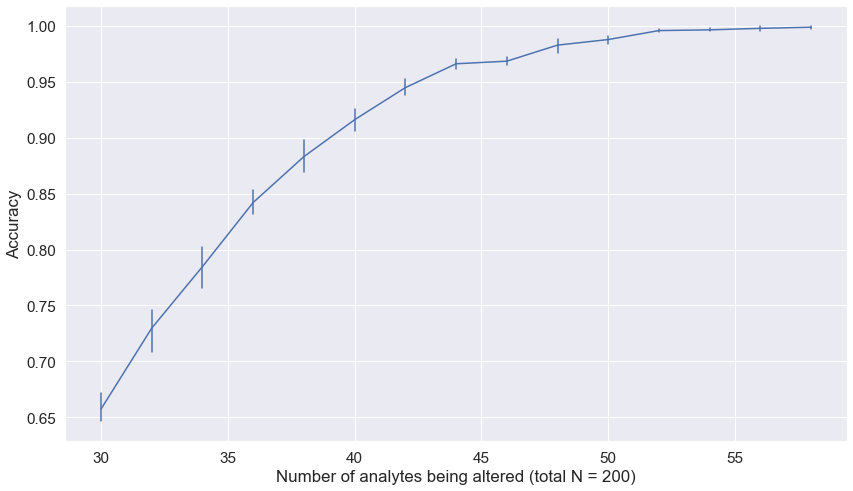

In [60]:
# save accuracy results in a dataframe
df_accu1 = pd.DataFrame({"accuracy":accuracy, "num_analyte":num_analyte})

# make a line plot
plt.figure(figsize=(14, 8))
sns.set(font_scale=1.4)
fig = sns.lineplot(data=df_accu1, x="num_analyte", y="accuracy", err_style="bars")
fig.set_xlabel("Number of analytes being altered (total N = 200)")
fig.set_ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

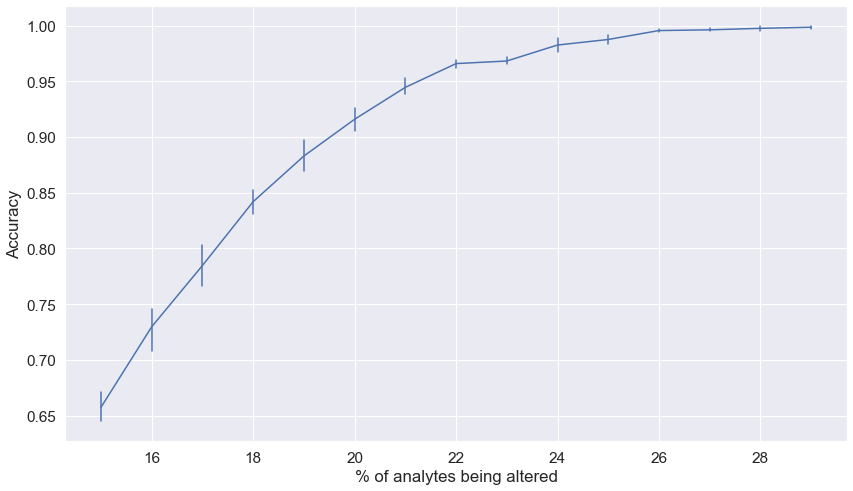

In [63]:
df_accu1["perct"] = df_accu1["num_analyte"]*100/200

plt.figure(figsize=(14, 8))
sns.set(font_scale=1.4)
fig = sns.lineplot(data=df_accu1, x="perct", y="accuracy", err_style="bars")
fig.set_xlabel("% of analytes being altered")
fig.set_ylabel("Accuracy")

This visualization provides valuable insights into the detection performance as the number of affected analytes varies.

Furthermore, we can assess how the variability of analyte concentrations affects the results. Statistically, we anticipate that affected analytes with lower variability will exert a greater influence on detectability compared to those with higher variability. By considering the variabilities of analytes, we can gain a deeper understanding of how different factors contribute to the detection outcomes.

In [ ]:
# accuracy estimation of altered analytes between high vs. low variability 
accuracy = []
num_analyte = []
variability = []

for num_ana in tqdm(range(30, 60, 2)):
    for i in range(6):
        accu_high = detection_accuracy(data_ref, iterations=500, num_analyte=num_ana,
                                  analyte_select_method="high", conc_percentile=(0,5), 
                                  eps=19.6, msg=False)
        accuracy.append(accu_high)
        num_analyte.append(num_ana)
        variability.append("high")

        accu_low = detection_accuracy(data_ref, iterations=500, num_analyte=num_ana,
                                  analyte_select_method="low", conc_percentile=(0,5), 
                                  eps=19.6, msg=False)
        
        accuracy.append(accu_low)
        num_analyte.append(num_ana)
        variability.append("low")


Text(0, 0.5, 'Accuracy')

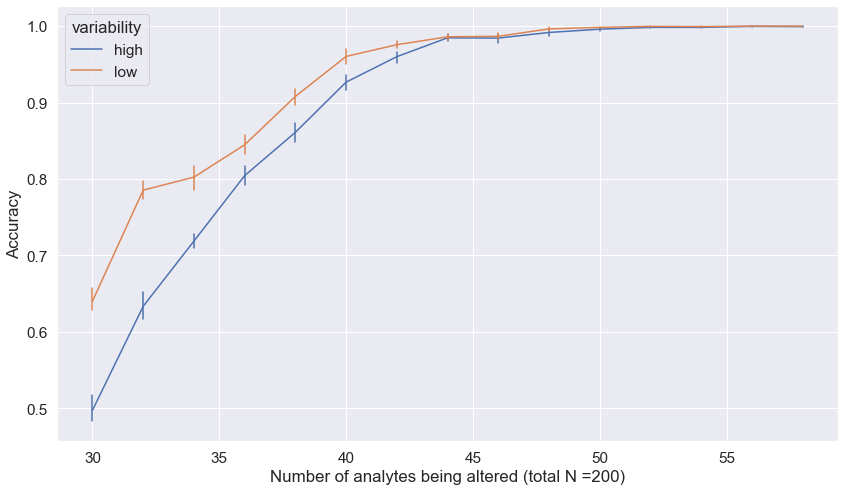

In [70]:
df_accu2 = pd.DataFrame({"accuracy":accuracy, "num_analyte":num_analyte, "variability":variability})
df_accu2["perct"] = df_accu2["num_analyte"]*100/200

plt.figure(figsize=(14, 8))
sns.set(font_scale=1.4)
fig = sns.lineplot(data=df_accu2, x="num_analyte", y="accuracy", hue="variability", err_style="bars")
fig.set_xlabel("Number of analytes being altered (total N =200)")
fig.set_ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

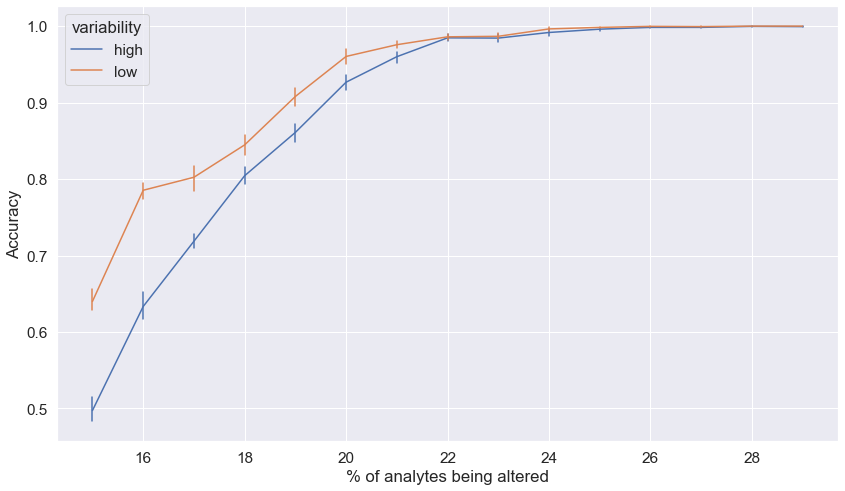

In [71]:
plt.figure(figsize=(14, 8))
sns.set(font_scale=1.4)
fig = sns.lineplot(data=df_accu2, x="perct", y="accuracy", hue="variability", err_style="bars")
fig.set_xlabel("% of analytes being altered")
fig.set_ylabel("Accuracy")

As expected, when considering the same number of affected analytes (less than 22% of total analytes), analytes with lower variability in concentrations (orange) consistently yielded higher accuracy compared to those with higher variability (blue). Interestingly, as the number or percentage of affected analytes increased, the accuracy improved and reached a maximum of 1, irrespective of the variability in analyte concentrations. This observation highlights the increasing effectiveness of the detection model as more analytes are influenced by adulteration, regardless of their initial variability.